# 確率ロボティクス2017第13回

上田隆一

2017年12月6日@千葉工業大学

## 今日やること

* 多変量正規（ガウス）分布
* 拡張カルマンフィルタ

## 多変量正規（ガウス）分布

* こういう式
  * $p(\boldsymbol{x}) = \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}e^{-\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})}$\par
    $= \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp\left\{-\dfrac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})\right\}$
    * $n$は$\boldsymbol{x}$の次元
* 以後単に「ガウス分布」と呼びます  
* 性質
  * $\boldsymbol{x}$の定義域で積分すると1（確率密度分布になっている）
    * $\boldsymbol{\mu}$が平均値
    * $\Sigma$が共分散行列（正確には分散共分散行列）
      * $\boldsymbol{x}$が2次元の場合: $\Sigma = \begin{pmatrix}\sigma_{xx},\sigma_{xy}\\\sigma_{xy}, \sigma_{yy}\end{pmatrix}$
        * $\sigma_{xx},\sigma_{yy}$: 分散
        * $\sigma_{xy}$: 共分散
  * ガウス分布同士の積もガウス分布
    * **確率の計算のときに平均と共分散だけ気にすればよい**
  * 多くの事象がガウス分布に従う
    * 雑音など
    

### ガウス分布のプログラミング

Pythonのライブラリを使って2次元のガウス分布の描画をしてみましょう。

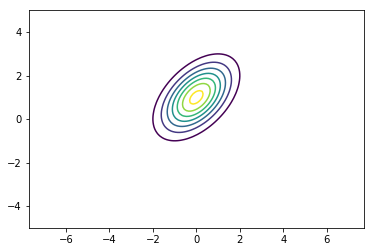

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

###平均と共分散行列###
mean = [0.0,1.0]
cov = [[1.0,0.5],
       [0.5,1.0]]

x_axis = np.linspace(-5, 5, 100)  #-5から5まで100刻みでリストを作る
y_axis = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_axis,y_axis) #x_axisとy_axisから平面上の格子を作る

###bivariate_normal: 二次元のガウス分布の値を格子に対して求めるメソッド###
Z = mlab.bivariate_normal(X, Y, # 格子の座標
                          math.sqrt(cov[0][0]),math.sqrt(cov[1][1]),# x,yの標準偏差
                          mean[0], mean[1], # 平均
                          cov[0][1])            # 共分散

plt.contour(X, Y, Z)
plt.axis("equal")
plt.show()

### 自作のガウス分布クラス

In [10]:
from matplotlib.patches import Ellipse

class Gaussian2D:
    def __init__(self,mu_x,mu_y,sigma_xx,sigma_yy,sigma_xy):
        self.cov = np.array([[sigma_xx,sigma_xy],
                             [sigma_xy,sigma_yy]])
        self.mean = np.array([[mu_x],[mu_y]])
        
    # 値（密度）を返すメソッド
    def value(self,x,y):
        pos = np.array([[x],[y]])
        delta = pos - self.mean
        numerator = math.exp(-0.5 * (delta.T).dot(self.cov.I).dot(delta))
        denominator = 2 * math.pi * math.sqrt(np.linalg.det(self.cov))
        return numerator / denominator
    
    # ガウス分布を移動させるメソッド
    def shift(self,delta,angle):
        ###回転行列を作る###
        ca = math.cos(angle)
        sa = math.sin(angle)
        rot = np.array([[ca,sa],[-sa,ca]])
        
        self.cov = rot.dot(self.cov).dot(rot.T) #共分散行列を回転行列で挟む
        self.mean = self.mean + delta           #平均値はそのままシフト
        
    # 誤差楕円（ここでは単なる固有ベクトルを長軸、短軸にした楕円）を返すメソッド
    def ellipse(self):
        eigen = np.linalg.eig(self.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        print(v1)
        print(v2)
        v1_direction = math.atan2(v1[1],v1[0])
        
        e = Ellipse(self.mean,width=np.linalg.norm(v1),height=np.linalg.norm(v2),angle=v1_direction/math.pi*180)
        e.set_alpha(0.2)
        
        return e

[ 1.06066017 -1.06066017]
[ 0.35355339  0.35355339]


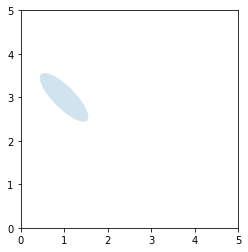

In [13]:
p = Gaussian2D(1.0,3.0,1.0,1.0,0.5)

fig = plt.figure(0)
sp = fig.add_subplot(111, aspect='equal')

plt.xlim(0,5)
plt.ylim(0,5)
sp.add_artist(p.ellipse())

plt.show()

## 拡張カルマンフィルタ

* ベイズフィルタをガウス分布に限定したもの
* 制御出力後の変更（motion update）
  * 移動後の$\hat{bel}_t$:
    * 中心: $\hat{\boldsymbol{x}}_t = f(\boldsymbol{\bar{x}}_{t-1},\boldsymbol{u}_t)$
      * 雑音を考慮しない状態方程式で出力前の推定の中心を移動させたもの
      * $\bar{x}_{t-1}$: $bel_{t-1}$の中心
    * 共分散: $\hat\Sigma_t = F_t\bar\Sigma_{t-1}F_t^T + R_t$
      * $\bar\Sigma_{t-1}$: $bel_{t-1}$の共分散
      * $F_t$:$\bar\Sigma_{t-1}$まわりで状態遷移関数$f$から作ったヤコビ行列   
      * $R_t$: 移動の雑音の共分散行列（事前に計測しておく）
